In [1]:
import choclo
import harmonica as hm
import micromag as mg
import numba
import numpy as np
import pandas as pd
import scipy as sp
import verde as vd
import xarray as xr

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[-100, 100, -100, 100],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Now create the dipole model that will be used to generate the data.

In [3]:
dipole_coordinates = np.array([0, 0, -5])
dipole_moments = mg.angles_to_vector(
    inclination=0,
    declination=0,
    amplitude=1.0e-15,
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print(dipole_coordinates)
print(dipole_moments)

[ 0  0 -5]
[ 0.e+00  1.e-15 -0.e+00]


In [4]:
# bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
# data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data = vd.make_xarray_grid(
    coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z"
)
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}


# Add some random noise to make it more realistic.
noise_std_dev = 2  # nT
# data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)
data.bz.values += mg.qdm_noise(data.bz.shape, noise_std_dev, seed=42)


# Add a positive shift to the data (background in the shielded room)
# data.bz.values += 400 # nT

data

<xarray.Dataset> Size: 165kB
Dimensions:  (y: 101, x: 101)
Coordinates:
  * x        (x) float64 808B -100.0 -98.0 -96.0 -94.0 ... 94.0 96.0 98.0 100.0
  * y        (y) float64 808B -100.0 -98.0 -96.0 -94.0 ... 94.0 96.0 98.0 100.0
    z        (y, x) float64 82kB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 82kB 0.2557 2.381 -1.656 ... 0.08754 -0.1963 0.9474

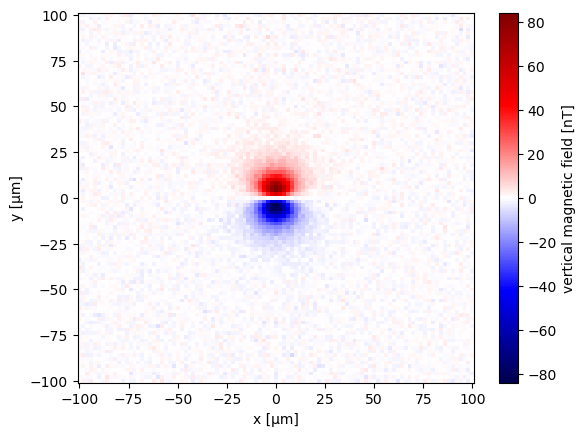

In [5]:
data.bz.plot.pcolormesh(cmap="seismic")  # , vmax=10000, vmin=-10000)

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [ ]:
# height_difference = 2.0

# # Have to assign the same points as the data because the Harmonica
# # transforms give slightly different coordinates due to round-off.
# # This is a bug and is being worked on.
# data_up = (
#     hm.upward_continuation(data.bz, height_difference)
#     .assign_attrs(data.bz.attrs)
#     .to_dataset(name="bz")
#     .assign_coords(x=data.x, y=data.y)
#     .assign_coords(z=data.z + height_difference)
# )
# data_up = data_up.assign(mg.data_gradients(data_up.bz))
# data_up

In [7]:
# data_up.bz.plot.pcolormesh(cmap="seismic")  # , vmax=50000, vmin=-50000)

# Euler Deconvolution and Inversion (Standard method)

In [8]:
# anomaly = data_up
data = data.assign(mg.data_gradients(data.bz))
anomaly = data
position, base_level = mg.euler_deconvolution(
    anomaly.bz,
    anomaly.x_deriv,
    anomaly.y_deriv,
    anomaly.z_deriv,
)


data_minus_background = anomaly.bz.values - base_level
anomaly = anomaly.assign(data_minus_background=(["y", "x"], data_minus_background))
anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

moment, covariance, r2, SNR = mg.dipole_moment_inversion(
    anomaly.data_minus_background,
    position,
)

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [9]:
# Initial Guesses
print(position)
print(moment)

[-0.64727832 -0.28376644  3.80285591]
[ 8.16827877e-19  9.25531975e-18 -4.72065168e-18]


# Nonlinear Inversion

\begin{equation}
b_z = 
m_x \dfrac{3(z - z_c)(x - x_c)}{\left[ (x - x_c)^2 + (y - y_c)^2 + (z - z_c)^2 \right]^{5/2}} + m_y \dfrac{3(z - z_c)(y - y_c)}{\left[ (x - x_c)^2 + (y - y_c)^2 + (z - z_c)^2 \right]^{5/2}} + m_z \left(     \dfrac{3(z - z_c)^2}{\left[ (x - x_c)^2 + (y - y_c)^2 + (z - z_c)^2 \right]^{5/2}}      - \dfrac{1}{\left[ (x - x_c)^2 + (y - y_c)^2 + (z - z_c)^2 \right]^{3/2}} \right) 
\end{equation}
\
\begin{equation}
\frac{\partial b_z}{\partial x_c}=
\frac{15m_{y} \left(y - y_{c}\right) \left(z - z_{c}\right) \left(x - x_{c}\right)}{\left(\left(x - x_{c}\right)^{2} + \left(z - z_{c}\right)^{2} + \left(y - y_{c}\right)^{2}\right)^{\frac{7}{2}}} + m_{z} \left(\frac{15 \left(z - z_{c}\right)^{2} \left(x - x_{c}\right)}{\left(\left(x - x_{c}\right)^{2} + \left(z - z_{c}\right)^{2} + \left(y - y_{c}\right)^{2}\right)^{\frac{7}{2}}} - \frac{3 \left(x - x_{c}\right)}{\left(\left(x - x_{c}\right)^{2} + \left(z - z_{c}\right)^{2} + \left(y - y_{c}\right)^{2}\right)^{\frac{5}{2}}}\right) + \frac{15m_{x} \left(z - z_{c}\right) \left(x - x_{c}\right)^{2}}{\left(\left(x - x_{c}\right)^{2} + \left(z - z_{c}\right)^{2} + \left(y - y_{c}\right)^{2}\right)^{\frac{7}{2}}} - \frac{3m_{x} \left(z - z_{c}\right)}{\left(\left(x - x_{c}\right)^{2} + \left(z - z_{c}\right)^{2} + \left(y - y_{c}\right)^{2}\right)^{\frac{5}{2}}}
\end{equation}
\
\begin{equation}
\frac{\partial b_z}{\partial y_c}=
\frac{15m_{x} \left(x - x_{c}\right) \left(z - z_{c}\right) \left(y - y_{c}\right)}{\left(\left(y - y_{c}\right)^{2} + \left(z - z_{c}\right)^{2} + \left(x - x_{c}\right)^{2}\right)^{\frac{7}{2}}} + m_{z} \left(\frac{15 \left(z - z_{c}\right)^{2} \left(y - y_{c}\right)}{\left(\left(y - y_{c}\right)^{2} + \left(z - z_{c}\right)^{2} + \left(x - x_{c}\right)^{2}\right)^{\frac{7}{2}}} - \frac{3 \left(y - y_{c}\right)}{\left(\left(y - y_{c}\right)^{2} + \left(z - z_{c}\right)^{2} + \left(x - x_{c}\right)^{2}\right)^{\frac{5}{2}}}\right) + \frac{15m_{y} \left(z - z_{c}\right) \left(y - y_{c}\right)^{2}}{\left(\left(y - y_{c}\right)^{2} + \left(z - z_{c}\right)^{2} + \left(x - x_{c}\right)^{2}\right)^{\frac{7}{2}}} - \frac{3m_{y} \left(z - z_{c}\right)}{\left(\left(y - y_{c}\right)^{2} + \left(z - z_{c}\right)^{2} + \left(x - x_{c}\right)^{2}\right)^{\frac{5}{2}}}
\end{equation}
\
\begin{equation}
\frac{\partial b_z}{\partial z_c}=
m_{z} \left(\frac{15 \left(z - z_{c}\right)^{3}}{\left(\left(z - z_{c}\right)^{2} + \left(y - y_{c}\right)^{2} + \left(x - x_{c}\right)^{2}\right)^{\frac{7}{2}}} - \frac{9 \left(z - z_{c}\right)}{\left(\left(z - z_{c}\right)^{2} + \left(y - y_{c}\right)^{2} + \left(x - x_{c}\right)^{2}\right)^{\frac{5}{2}}}\right) + \frac{15m_{y} \left(y - y_{c}\right) \left(z - z_{c}\right)^{2}}{\left(\left(z - z_{c}\right)^{2} + \left(y - y_{c}\right)^{2} + \left(x - x_{c}\right)^{2}\right)^{\frac{7}{2}}} + \frac{15m_{x} \left(x - x_{c}\right) \left(z - z_{c}\right)^{2}}{\left(\left(z - z_{c}\right)^{2} + \left(y - y_{c}\right)^{2} + \left(x - x_{c}\right)^{2}\right)^{\frac{7}{2}}} - \frac{3m_{y} \left(y - y_{c}\right)}{\left(\left(z - z_{c}\right)^{2} + \left(y - y_{c}\right)^{2} + \left(x - x_{c}\right)^{2}\right)^{\frac{5}{2}}} - \frac{3m_{x} \left(x - x_{c}\right)}{\left(\left(z - z_{c}\right)^{2} + \left(y - y_{c}\right)^{2} + \left(x - x_{c}\right)^{2}\right)^{\frac{5}{2}}}
\end{equation}




In [10]:
def position_nonlinear_inversion(data, coordinates, dipole_coordinates, moment):
    n_data = np.size(data)
    n_params = 3
    A = np.empty((n_data, n_params))
    d = data / mg.TESLA_TO_NANOTESLA
    # Fill the Jacobian using a fast calculation with numba
    _jacobian_kernel(
        coordinates[0] * mg.MICROMETER_TO_METER,
        coordinates[1] * mg.MICROMETER_TO_METER,
        coordinates[2] * mg.MICROMETER_TO_METER,
        dipole_coordinates[0] * mg.MICROMETER_TO_METER,
        dipole_coordinates[1] * mg.MICROMETER_TO_METER,
        dipole_coordinates[2] * mg.MICROMETER_TO_METER,
        moment[0],
        moment[1],
        moment[2],
        A,
    )
    hessian = A.T @ A
    neg_gradient = A.T @ d
    position = sp.linalg.solve(hessian, neg_gradient, assume_a="pos")

    return position


def _jacobian_kernel(x, y, z, xc, yc, zc, mx, my, mz, result):
    factor = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for i in numba.prange(x.size):
        dx = x[i] - xc
        dy = y[i] - yc
        dz = z[i] - zc

        r2 = dx**2 + dy**2 + dz**2
        r5 = r2 ** (5 / 2)
        r7 = r2 ** (7 / 2)

        # ∂bz / ∂xc (exatamente como na equação)
        dBz_dxc = factor * (
            (15 * my * dy * dz * dx) / r7
            + mz * ((15 * dz**2 * dx) / r7 - (3 * dx) / r5)
            + (15 * mx * dz * dx**2) / r7
            - (3 * mx * dz) / r5
        )

        # ∂bz / ∂yc
        dBz_dyc = factor * (
            (15 * mx * dx * dz * dy) / r7
            + mz * ((15 * dz**2 * dy) / r7 - (3 * dy) / r5)
            + (15 * my * dz * dy**2) / r7
            - (3 * my * dz) / r5
        )

        # ∂bz / ∂zc
        dBz_dzc = factor * (
            mz * ((15 * dz**3) / r7 - (9 * dz) / r5)
            + (15 * my * dy * dz**2) / r7
            - (3 * my * dy) / r5
            + (15 * mx * dx * dz**2) / r7
            - (3 * mx * dx) / r5
        )

        result[i, 0] = dBz_dxc
        result[i, 1] = dBz_dyc
        result[i, 2] = dBz_dzc

In [11]:
def Gauss_Newton_Levenberg_Marquardt(
    data, position, max_iter=100, tol=1e-10, lambda_init=1e-2, lambda_scale=10.0
):
    table = vd.grid_to_table(data)
    coordinates = np.array([table.x.values, table.y.values, table.z.values])

    d = data.bz.values.ravel()
    misfit = []

    lambda_ = lambda_init

    for i in range(max_iter):
        # Estimar momento magnético com a posição atual
        moment, _, r2, _ = mg.dipole_moment_inversion(data.bz, position)

        # Predizer o campo com esses parâmetros
        predicted_data = mg.dipole_bz(coordinates, position, moment)
        residual = d - predicted_data
        current_misfit = np.linalg.norm(residual) ** 2
        misfit.append(current_misfit)

        A = np.empty((d.size, 3))
        _jacobian_kernel(
            coordinates[0] * mg.MICROMETER_TO_METER,
            coordinates[1] * mg.MICROMETER_TO_METER,
            coordinates[2] * mg.MICROMETER_TO_METER,
            position[0] * mg.MICROMETER_TO_METER,
            position[1] * mg.MICROMETER_TO_METER,
            position[2] * mg.MICROMETER_TO_METER,
            moment[0],
            moment[1],
            moment[2],
            A,
        )

        JTJ = A.T @ A
        JTr = A.T @ (residual)

        accepted = False

        for _ in range(50):  # tentativas para um bom passo
            delta = np.linalg.solve(JTJ + lambda_ * np.eye(3), JTr)
            trial_position = position + delta

            # Novo momento e resíduo com nova posição
            trial_moment, _, _, _ = mg.dipole_moment_inversion(data.bz, trial_position)
            trial_pred = mg.dipole_bz(coordinates, trial_position, trial_moment)
            trial_residual = d - trial_pred
            trial_misfit = np.linalg.norm(trial_residual) ** 2

            if trial_misfit < current_misfit:
                # Aceita o passo: melhora
                position = trial_position
                lambda_ /= lambda_scale
                misfit.append(trial_misfit)
                accepted = True
                break
            else:
                # Rejeita o passo: piora
                lambda_ *= lambda_scale

        print(
            f"Iter {i:02d} | λ = {lambda_:.1e} | Δpos = {delta} | ‖Δpos‖ = {np.linalg.norm(delta):.2e} | R² = {r2:.6f}"
        )

        if not accepted:
            print("→ Parou: nenhum passo foi aceito")
            break

        if abs(misfit[-1] - misfit[-2]) / misfit[-2] < tol:
            print("→ Parou: convergência por tolerância")
            break

    return position, moment

In [12]:
# Run Linear Inversion to apply as initial guess
anomaly = data_up
position, base_level = mg.euler_deconvolution(
    anomaly.bz,
    anomaly.x_deriv,
    anomaly.y_deriv,
    anomaly.z_deriv,
)


data_minus_background = anomaly.bz.values - base_level
anomaly = anomaly.assign(data_minus_background=(["y", "x"], data_minus_background))
anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

moment, covariance, r2, SNR = mg.dipole_moment_inversion(
    anomaly.data_minus_background,
    position,
)
print(moment)
# save initial guess for comparison later
bubble_pos, bubble_m = position, moment

# Run nonlinear position inversion
position, moment = Gauss_Newton_Levenberg_Marquardt(data, position)

NameError: name 'data_up' is not defined

In [13]:
print(f" guess position: {bubble_pos}")
print(f" final position: {position}")
print(f" true position:  {dipole_coordinates}")
print()
print(f" guess moment: {bubble_m}")
print(f" final moment: {moment}")
print(f" true moment:  {dipole_moments}")

 guess position: [-0.06252826  0.01937847 -2.99970687]
 final position: [ 4.07314806e-03  6.67088276e-03 -5.03328166e+00]
 true position:  [ 0  0 -5]

 guess moment: [-6.98671333e-19  6.85159137e-16  1.23446335e-18]
 final moment: [-6.58663135e-19  1.00926137e-15  4.26692353e-19]
 true moment:  [ 0.e+00  1.e-15 -0.e+00]
